In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from tqdm import tqdm
import numpy as np

import xarray as xr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torchvision

import lightning as pl
from lightning import Trainer

import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('medium')

In [7]:
nn.Linear(20, 10).weight.shape

torch.Size([10, 20])

## Model

In [88]:
class NeRF(pl.LightningModule):
    def __init__(self, input_size: int, 
                 n_hidden_layer_neurons: list, 
                 output_shape: int, 
                 activation: callable, 
                 lr: float,
                 ):
        super().__init__()

        self.activation = activation
        self.n_hidden_layer_neurons = n_hidden_layer_neurons
        self.lr = lr
        self.save_hyperparameters()
        self.history = []

        self.input = nn.Linear(input_size, n_hidden_layer_neurons[0])
        for i in range(1, len(n_hidden_layer_neurons)):
            setattr(self, f"linear{i}", nn.Linear(n_hidden_layer_neurons[i-1], n_hidden_layer_neurons[i]))
        
        self.final = nn.Linear(n_hidden_layer_neurons[-1], output_shape)

    def forward(self, x):
        x = self.activation(self.input(x))
        for i in range(1, len(self.n_hidden_layer_neurons)):
            x = self.activation(getattr(self, f"linear{i}")(x))
        return self.final(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = ((y_hat - y)**2).mean()
        self.log('train_loss', loss)
        self.history.append(loss.item())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Load AQ data

In [89]:
data = xr.open_dataset("../data/delhi_cpcb_2022.nc")
df = data.to_dataframe().reset_index().set_index("time")
df = df.loc["2022"].reset_index()

# convert time to hours starting from 2022
df["time"] = (df["time"] - df["time"].min()) / np.timedelta64(1, 'h')

assert df.shape[0] == 365*24*40 == 350400 # 40 stations for 365 days and 24 hours (including missing data)

In [90]:
# drop missing data
size_before = df.shape[0]
train_data = df[["latitude", "longitude", "time", "PM2.5"]].dropna(how="any", axis=0)
train_data["PM2.5"] = train_data["PM2.5"].apply(lambda x: np.nan if x > 500 else x)
train_data = train_data.dropna(how="any", axis=0)
size_after = train_data.shape[0]
print(f"dropped {size_before - size_after} rows with missing data. Percentage: {(size_before - size_after)/size_before*100:.2f}%")

dropped 34912 rows with missing data. Percentage: 9.96%


In [91]:
train_x = train_data[["latitude", "longitude", "time"]].values
scaler_x = MinMaxScaler((0, 1))
train_x = scaler_x.fit_transform(train_x)

scaler_y = MinMaxScaler((0, 1))
train_y = train_data[["PM2.5"]].values
train_y = scaler_y.fit_transform(train_y)

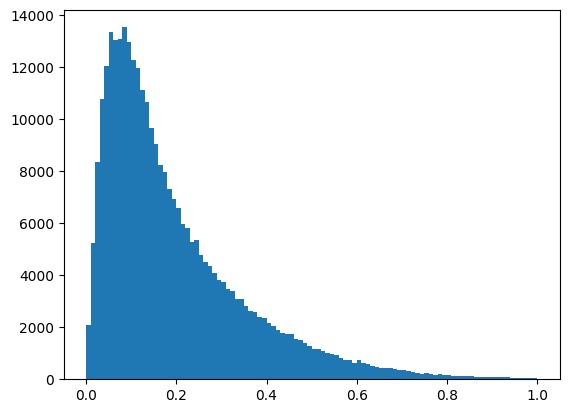

In [92]:
plt.hist(train_y, bins=100);

## Fit ReLU model

In [106]:
relu_nn = NeRF(input_size=3, n_hidden_layer_neurons=[256, 256, 256, 256, 256], output_shape=1, activation=F.relu, lr=1e-4)

train_loader = DataLoader(
    TensorDataset(torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)),
    batch_size=len(train_y),
    shuffle=True,
    num_workers=32,
)

# x, y = next(iter(train_loader))
# for i in tqdm(range(10)):
#     pred_y = relu_nn(x)

trainer = Trainer(max_epochs=100, devices=1)
trainer.fit(relu_nn, train_loader)

TypeError: 'module' object is not callable

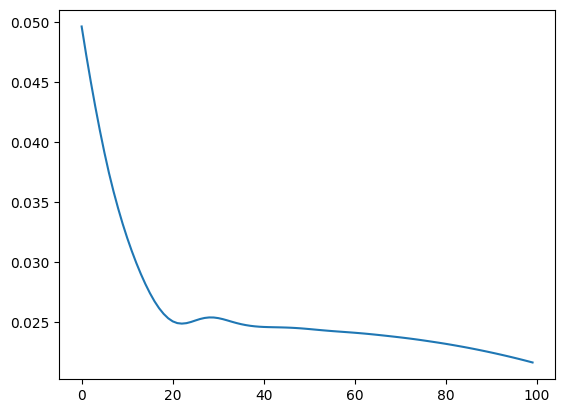

In [101]:
plt.plot(relu_nn.history);

In [102]:
pred_y = relu_nn(torch.tensor(train_x, dtype=torch.float32)).detach().numpy()
pred_y_ = scaler_y.inverse_transform(pred_y)
train_y_ = scaler_y.inverse_transform(train_y)

loss = np.sqrt(np.mean((pred_y_ - train_y_)**2))
loss
# 61.927111099932446 relu loss

73.37065767109755

In [103]:
# np.sort(train_y_, axis=0)[-1000:]

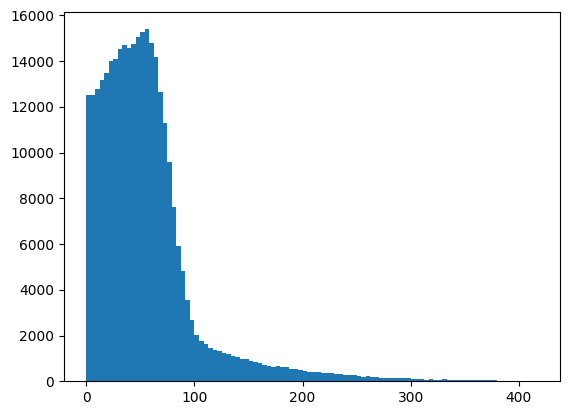

In [104]:
plt.hist(np.abs((pred_y_ - train_y_)), bins=100);

Text(0, 0.5, 'Predicted PM2.5')

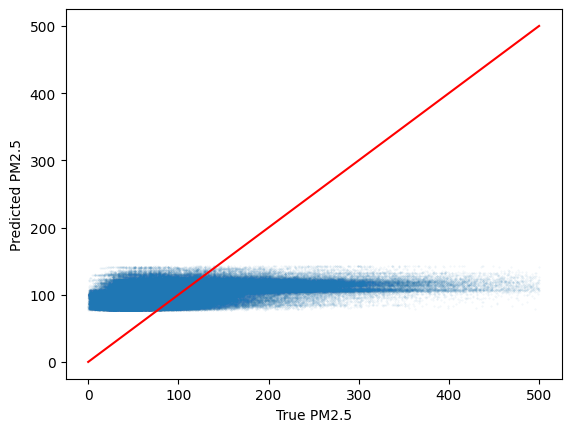

In [105]:
plt.scatter(train_y_, pred_y_, alpha=0.1, s=0.1);
plt.plot([0, 500], [0, 500], color="red")
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
# plt.xlim(0, 1000)
# plt.ylim(0, 1000);
# plt.xlim(0, 1)
# plt.ylim(0, 1);

In [23]:
# x, y = next(iter(train_loader))
# pred_y = relu_nn(x)
# loss = ((pred_y - y)**2).nanmean()
# print(loss)
# loss.backward()
# for name, param in relu_nn.named_parameters():
#     print(name, param.grad)